In [ ]:
import os
import xml.etree.ElementTree as ET

# Paths (fixed for nested folder from Kaggle unzip)
data_root = '/content/VOC_dataset/VOC_dataset/VOCdevkit'  # Adjusted for /VOC_dataset/VOC_dataset/
years = ['VOC2007', 'VOC2012']
output_dir = '/content/data/original_labels'
os.makedirs(output_dir, exist_ok=True)

# Class mapping
classes = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
           'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
class_to_id = {cls: i for i, cls in enumerate(classes)}

for year in years:
    annotations_dir = os.path.join(data_root, year, 'Annotations')
    for xml_file in os.listdir(annotations_dir):
        if not xml_file.endswith('.xml'):
            continue
        xml_path = os.path.join(annotations_dir, xml_file)
        tree = ET.parse(xml_path)
        root = tree.getroot()

        img_filename = root.find('filename').text
        width = int(root.find('size/width').text)
        height = int(root.find('size/height').text)

        txt_lines = []
        for obj in root.iter('object'):
            cls_name = obj.find('name').text.lower()
            if cls_name not in class_to_id:
                continue
            cls_id = class_to_id[cls_name]

            bndbox = obj.find('bndbox')
            xmin = float(bndbox.find('xmin').text)
            ymin = float(bndbox.find('ymin').text)
            xmax = float(bndbox.find('xmax').text)
            ymax = float(bndbox.find('ymax').text)

            # Normalization for YOLO
            x_center = (xmin + xmax) / 2 / width
            y_center = (ymin + ymax) / 2 / height
            w = (xmax - xmin) / width
            h = (ymax - ymin) / height

            txt_lines.append(f"{cls_id} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}")

        # Save TXT
        txt_path = os.path.join(output_dir, xml_file.replace('.xml', '.txt'))
        if txt_lines:
            with open(txt_path, 'w') as f:
                f.write('\n'.join(txt_lines))

print("Conversion completed! TXT in /content/data/original_labels")

Conversion completed! TXT in /content/data/original_labels


In [ ]:
import os
import shutil

def create_custom_splits_and_copy(years, base_dir, output_base='/content/data/custom_data'):
    # Create folders for images and labels in custom_data
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(output_base, 'images', split), exist_ok=True)
        os.makedirs(os.path.join(output_base, 'labels', split), exist_ok=True)

    # Dictionaries for splits (train based on trainval for more data)
    splits = {
        'train': 'trainval',
        'val': 'val',
        'test': 'test'
    }

    # Collect unique IDs for each split
    all_splits = {split: set() for split in splits}

    for year in years:
        imagesets_dir = os.path.join(base_dir, year, 'ImageSets/Main')
        jpeg_dir = os.path.join(base_dir, year, 'JPEGImages')

        for split, original_txt in splits.items():
            txt_path = os.path.join(imagesets_dir, f'{original_txt}.txt')
            if os.path.exists(txt_path):
                with open(txt_path, 'r') as f:
                    ids = [line.strip() for line in f if line.strip()]
                all_splits[split].update(ids)

    # Copy files with prefixes for uniqueness
    for split in all_splits:
        for img_id in all_splits[split]:
            for year in years:
                original_jpg = os.path.join(base_dir, year, 'JPEGImages', f'{img_id}.jpg')
                original_txt = os.path.join('/content/data/original_labels', f'{img_id}.txt')

                if os.path.exists(original_jpg) and os.path.exists(original_txt):
                    new_id = f'{year}_{img_id}'  # Year prefix for uniqueness
                    new_jpg = os.path.join(output_base, 'images', split, f'{new_id}.jpg')
                    new_txt = os.path.join(output_base, 'labels', split, f'{new_id}.txt')

                    shutil.copy(original_jpg, new_jpg)
                    shutil.copy(original_txt, new_txt)
                    break

    # Creating custom TXT with new IDs (for .yaml)
    for split in all_splits:
        custom_txt_path = os.path.join(output_base, f'custom_{split}.txt')
        with open(custom_txt_path, 'w') as f:
            for img_id in sorted(all_splits[split]):
                for year in years:
                    if os.path.exists(os.path.join(base_dir, year, 'JPEGImages', f'{img_id}.jpg')):
                        f.write(f'{year}_{img_id}\n')
                        break

    print("Custom splits created and files copied to data/custom_data!")

create_custom_splits_and_copy(['VOC2007', 'VOC2012'], '/content/VOC_dataset/VOC_dataset/VOCdevkit', '/content/data/custom_data')

Custom splits created and files copied to data/custom_data!


Visualizing /content/data/custom_data/images/train/VOC2012_2010_000553.jpg


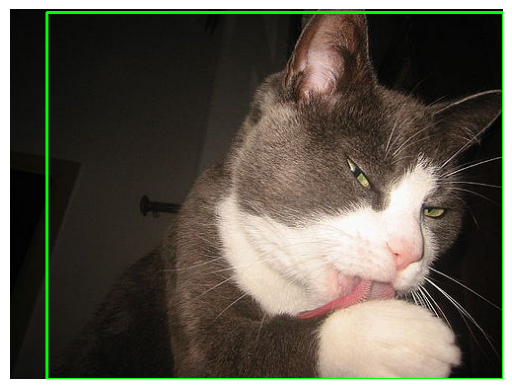

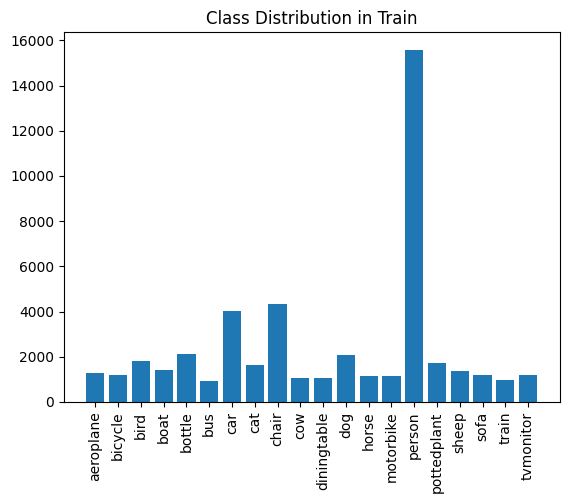

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np

# Paths (adapted for data/custom_data)
custom_data_root = '/content/data/custom_data'
split = 'train'
images_dir = os.path.join(custom_data_root, 'images', split)
labels_dir = os.path.join(custom_data_root, 'labels', split)
custom_txt = os.path.join(custom_data_root, f'custom_{split}.txt')

classes = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
           'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

# Read list of IDs from custom_train.txt
with open(custom_txt, 'r') as f:
    all_ids = [line.strip() for line in f if line.strip()]

# Function to visualize image with bounding boxes
def visualize_image_with_boxes(img_path, label_path, classes):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert for matplotlib
    h, w = img.shape[:2]

    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            lines = f.readlines()
        for line in lines:
            cls_id, x_center, y_center, width, height = map(float, line.strip().split())
            cls_name = classes[int(cls_id)]

            # Convert to absolute coordinates
            x1 = int((x_center - width / 2) * w)
            y1 = int((y_center - height / 2) * h)
            x2 = int((x_center + width / 2) * w)
            y2 = int((y_center + height / 2) * h)

            # Draw box and label
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img, cls_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Select random image
random_id = random.choice(all_ids)
img_path = os.path.join(images_dir, f'{random_id}.jpg')
label_path = os.path.join(labels_dir, f'{random_id}.txt')

print(f"Visualizing {img_path}")
visualize_image_with_boxes(img_path, label_path, classes)

# Statistics: class distribution in train
class_counts = np.zeros(len(classes))
for label_file in os.listdir(labels_dir):
    label_path = os.path.join(labels_dir, label_file)
    with open(label_path, 'r') as f:
        for line in f:
            cls_id = int(line.split()[0])
            class_counts[cls_id] += 1

plt.bar(classes, class_counts)
plt.xticks(rotation=90)
plt.title('Class Distribution in Train')
plt.show()

In [ ]:
from ultralytics import settings

# Set datasets_dir to empty to avoid prepending
settings.update({'datasets_dir': ''})

print("Settings updated! Datasets dir now:", settings['datasets_dir'])

Settings updated! Datasets dir now: 


In [ ]:
import torch
from ultralytics import YOLO

# Check if GPU is available
if torch.cuda.is_available():
    print(f"GPU is available! Device: {torch.cuda.get_device_name(0)}")
    device = 0  # Use GPU
else:
    print("GPU not available, falling back to CPU.")
    device = 'cpu'

# Load pre-trained YOLOv8 model (medium for GPU)
model = YOLO('yolov8m.pt')

# Train the model
results = model.train(
    data='/content/dataset.yaml',  # Path to YAML
    epochs=50,
    imgsz=640,
    batch=16,  # Batch size
    name='voc_detection_colab',
    patience=10,
    device=device
)

# Save the trained model to Colab or Drive
model.save('/content/voc_yolo_model.pt')
print(results)

GPU is available! Device: Tesla T4
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=voc_detection_colab, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=1

In [1]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True,garbage_collection_threshold:0.5'
import torch
torch.cuda.empty_cache()
print("Allocated:", torch.cuda.memory_allocated() / 1024**3, "GiB")
print("Reserved:", torch.cuda.memory_reserved() / 1024**3, "GiB")

Allocated: 0.0 GiB
Reserved: 0.0 GiB


In [2]:
from ultralytics import YOLO

# Check GPU
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    device = 0
else:
    device = 'cpu'

# Load larger model
model = YOLO('yolov8l.pt')  # Larger for better accuracy

# Train with augmentation
results = model.train(
    data='dataset.yaml',
    epochs=100,
    imgsz=416,
    batch=8,
    name='voc_improved_1',
    patience=20,
    device=0,
    mosaic=1.0,  # Augmentation
    mixup=0.2,
    copy_paste=0.1
)

model.save('voc_improved_1.pt')
print(results)

GPU: NVIDIA GeForce RTX 3060 Laptop GPU
Ultralytics 8.3.228  Python-3.13.9 torch-2.9.1+cu130 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.2, mode=train, model=yolov8l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=voc_improved_1, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=Tr

s:\Python_projects\Pythone_cousre\resume_projects\object_detection_cv\content\od_venv\Lib\site-packages\torch\nn\modules\module.py:1357: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:35.)
  return t.to(


AMP: checks passed 
train: Fast image access  (ping: 3.61.8 ms, read: 74.554.6 MB/s, size: 120.7 KB)
train: Scanning S:\Python_projects\Pythone_cousre\resume_projects\object_detection_cv\content\data\custom_data\labels\train.cache... 16551 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 16551/16551 21.3Mit/s 0.0s
WARNING val: Slow image access detected (ping: 11.014.3 ms, read: 173.7128.9 MB/s, size: 135.9 KB). Use local storage instead of remote/mounted storage for better performance. See https://docs.ultralytics.com/guides/model-training-tips/
val: Scanning S:\Python_projects\Pythone_cousre\resume_projects\object_detection_cv\content\data\custom_data\labels\val.cache... 8333 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 8333/8333 15.7Mit/s 0.0s
Plotting labels to S:\Python_projects\Pythone_cousre\resume_projects\object_detection_cv\content\runs\detect\voc_improved_1\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining be

KeyboardInterrupt: 

In [ ]:
from ultralytics import YOLO

model = YOLO('runs/detect/voc_improved_1/weights/last.pt')

results = model.train(resume=True)

Ultralytics 8.3.228  Python-3.13.9 torch-2.9.1+cu130 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.2, mode=train, model=runs\detect\voc_improved_1\weights\last.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=voc_improved_1, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, pati

KeyboardInterrupt: 

In [ ]:
from ultralytics import YOLO

model = YOLO('runs/detect/voc_improved_1/weights/last.pt')

results = model.train(resume=True)

Ultralytics 8.3.228  Python-3.13.9 torch-2.9.1+cu130 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.2, mode=train, model=runs\detect\voc_improved_1\weights\last.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=voc_improved_1, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, pati

In [1]:
from ultralytics import YOLO
import pandas as pd
import matplotlib.pyplot as plt

# Завантаж найкращу модель
model = YOLO('runs/detect/voc_improved_1/weights/best.pt')  # Шлях до best.pt (адаптуй, якщо треба)

# Оцінка на val set (перевірка overfitting)
metrics = model.val(data='dataset.yaml', split='val')
print("Val mAP50-95:", metrics.box.map)  # Якщо ~0.848 і не нижче train — ок

# Plot train/val loss для візуалізації (з results.csv)
df = pd.read_csv('runs/detect/voc_improved_1/results.csv')  # Шлях до results.csv
plt.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss')
plt.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()  # Якщо val loss не росте (близько train) — немає overfitting

Ultralytics 8.3.228  Python-3.13.9 torch-2.9.1+cu130 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 112 layers, 43,622,028 parameters, 0 gradients, 164.9 GFLOPs
val: Fast image access  (ping: 1.00.8 ms, read: 171.1121.3 MB/s, size: 117.3 KB)
val: Scanning S:\Python_projects\Pythone_cousre\resume_projects\object_detection_cv\content\data\custom_data\labels\val.cache... 8333 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 8333/8333 10.6Mit/s 0.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 521/521 2.9it/s 2:57<0.8ss
                   all       8333      23605      0.952      0.919      0.967      0.848
             aeroplane        475        659      0.985      0.909      0.966       0.87
               bicycle        423        596      0.968      0.924      0.969      0.857
                  bird        525        934       0.97      0.898      0.972      0.815
                  boat    

<Figure size 640x480 with 1 Axes>

In [3]:
from ultralytics import YOLO
import os

# Завантаж найкращу модель
model = YOLO('runs/detect/voc_improved_1/weights/best.pt')  # Шлях до best.pt (адаптуй, якщо треба)

# Predict на нових фото (папка img_for_test)
test_dir = 'img_for_test/'  # Шлях до твоєї папки
results = model.predict(source=test_dir, conf=0.5, save=True)  # Predict + save з boxes/conf в runs/predict/

# Вивід результатів (перевір кількість/класи)
for r in results:
    detected = [(r.names[int(c)], conf) for c, conf in zip(r.boxes.cls, r.boxes.conf)]  # Класи і conf
    print(f"Image: {os.path.basename(r.path)}, Detected: {len(r.boxes)} objects - {detected}")


image 1/17 s:\Python_projects\Pythone_cousre\resume_projects\object_detection_cv\content\img_for_test\pexels-arina-krasnikova-7726318.jpg: 416x288 2 cats, 95.8ms
image 2/17 s:\Python_projects\Pythone_cousre\resume_projects\object_detection_cv\content\img_for_test\pexels-charles-kettor-268979-1077785.jpg: 288x416 4 cars, 4 persons, 51.3ms
image 3/17 s:\Python_projects\Pythone_cousre\resume_projects\object_detection_cv\content\img_for_test\pexels-daniyal-gh-10741-110812.jpg: 288x416 2 birds, 50.7ms
image 4/17 s:\Python_projects\Pythone_cousre\resume_projects\object_detection_cv\content\img_for_test\pexels-enricoperini-804611.jpg: 320x416 2 cars, 58.5ms
image 5/17 s:\Python_projects\Pythone_cousre\resume_projects\object_detection_cv\content\img_for_test\pexels-francesco-ungaro-1761401.jpg: 288x416 2 cats, 51.7ms
image 6/17 s:\Python_projects\Pythone_cousre\resume_projects\object_detection_cv\content\img_for_test\pexels-kowalievska-1170986.jpg: 416x288 1 cat, 52.9ms
image 7/17 s:\Python_p